In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import re
from haversine import haversine, Unit

In [67]:
a = pd.read_csv("../data/apartments_train.csv")
b = pd.read_csv("../data/buildings_train.csv")
merged = a.merge(b, left_on='building_id', right_on='id')
merged.to_csv("prepared_data/apartments_and_building_train.csv", index=False)

a = pd.read_csv("../data/apartments_test.csv")
b = pd.read_csv("../data/buildings_test.csv")
merged = a.merge(b, left_on='building_id', right_on='id')
merged.to_csv("prepared_data/apartments_and_building_test.csv", index=False)

In [68]:
dfTrain = pd.read_csv("prepared_data/apartments_and_building_train.csv")
dfTest = pd.read_csv("prepared_data/apartments_and_building_test.csv")

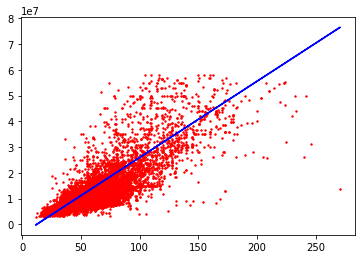

In [69]:
df = dfTrain.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
y = df["price"].copy()
X = df["area_total"].copy()
X_train = X[:10000]
y_train = y[:10000]
X_test  = X[10000:]
y_test  = y[10000:]
reg_model = LinearRegression()

reg_model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
y_pred = reg_model.predict(X_test.values.reshape(-1, 1))
plt.scatter(X_test, y_test, s=2, color = 'red')
plt.plot(X_test, reg_model.predict(X_test.values.reshape(-1, 1)), color = 'blue')

In [70]:
def get_distance_center(lat1, lon1):
    dist = haversine((lat1, lon1), (55.751244, 37.618423), unit=Unit.METERS)
    return round(dist/1000, 3)

In [71]:
dfTrain["distance_center"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)
dfTest["distance_center"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)

In [92]:
def get_distance_metro(lat, lon):
    shortest = np.inf
    for metro_coordinate in coordinates:
        dist = haversine(metro_coordinate, (lat, lon), unit=Unit.METERS)
        if dist < shortest:
            shortest = dist
    if shortest == np.inf:
        return 100
    return round(shortest/1000, 3)

In [93]:
# get chrome driver
driver = webdriver.Chrome(ChromeDriverManager().install())
# url for page to analyze
driver.get('https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations')
# content of the page
content = driver.page_source

# find all spans with coordinates
soup = BeautifulSoup(content, features="html.parser")
spans = soup.find_all('span', class_="geo-dec")
driver.quit()

coordinates = []
numbers = re.compile(r'\d+(?:\.\d+)?')
# iterate all spans with coordinates
for span in spans:
    coord = span.get_text()
    coord = numbers.findall(coord)
    coord = [float(x) for x in coord]
    coordinates.append(tuple(coord))

dfTrain["distance_metro"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_metro(x.latitude, x.longitude), axis=1)
dfTest["distance_metro"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_metro(x.latitude, x.longitude), axis=1)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 95.0.4638
[WDM] - Get LATEST driver version for 95.0.4638
[WDM] - Driver [C:\Users\erikm\.wdm\drivers\chromedriver\win32\95.0.4638.54\chromedriver.exe] found in cache
C:\Users\erikm\AppData\Local\Temp/ipykernel_31100/4127507770.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


<AxesSubplot:xlabel='distance_metro', ylabel='price'>

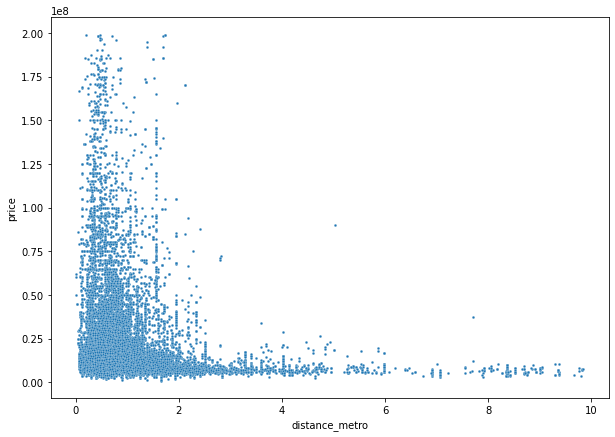

In [74]:
df = dfTrain.copy()
qhigh = df["price"].quantile(0.99)
df = df[(df["price"] < qhigh) & (df["distance_metro"] < 10)]
plt.figure(figsize=(10, 7))
sns.scatterplot(x="distance_metro", y="price", s=7, data=df)

In [94]:
def process_data(dataframe, keep_col):
    columns = dataframe.columns.values
    """ columns = ['building_id', 'id_x', 'id_y', 'seller', 'price', 'area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 
            'condition', 'phones', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 
            'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'parking', 'garbage_chute', 'heating', 'distance_center', 'distance_metro'] """
    
    keep_columns = ['area_total', 'floor', 'rooms', 'district', 'distance_center', 'distance_metro']
    for col in keep_col:
        keep_columns.append(col)

    remove_columns = [col for col in columns if col not in keep_columns]

    dataframe = dataframe.drop(remove_columns, axis=1)

    for column in keep_columns:
        #Finding the mean of the column having NaN
        mean_value=dataframe[column].mean()
        
        # Replace NaNs in column S2 with the
        # mean of values in the same column
        dataframe[column].fillna(value=mean_value, inplace=True)

    return dataframe

0.5363316789690511
0.25330149477447733


C:\Users\erikm\AppData\Local\Temp/ipykernel_31100/1738618646.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]


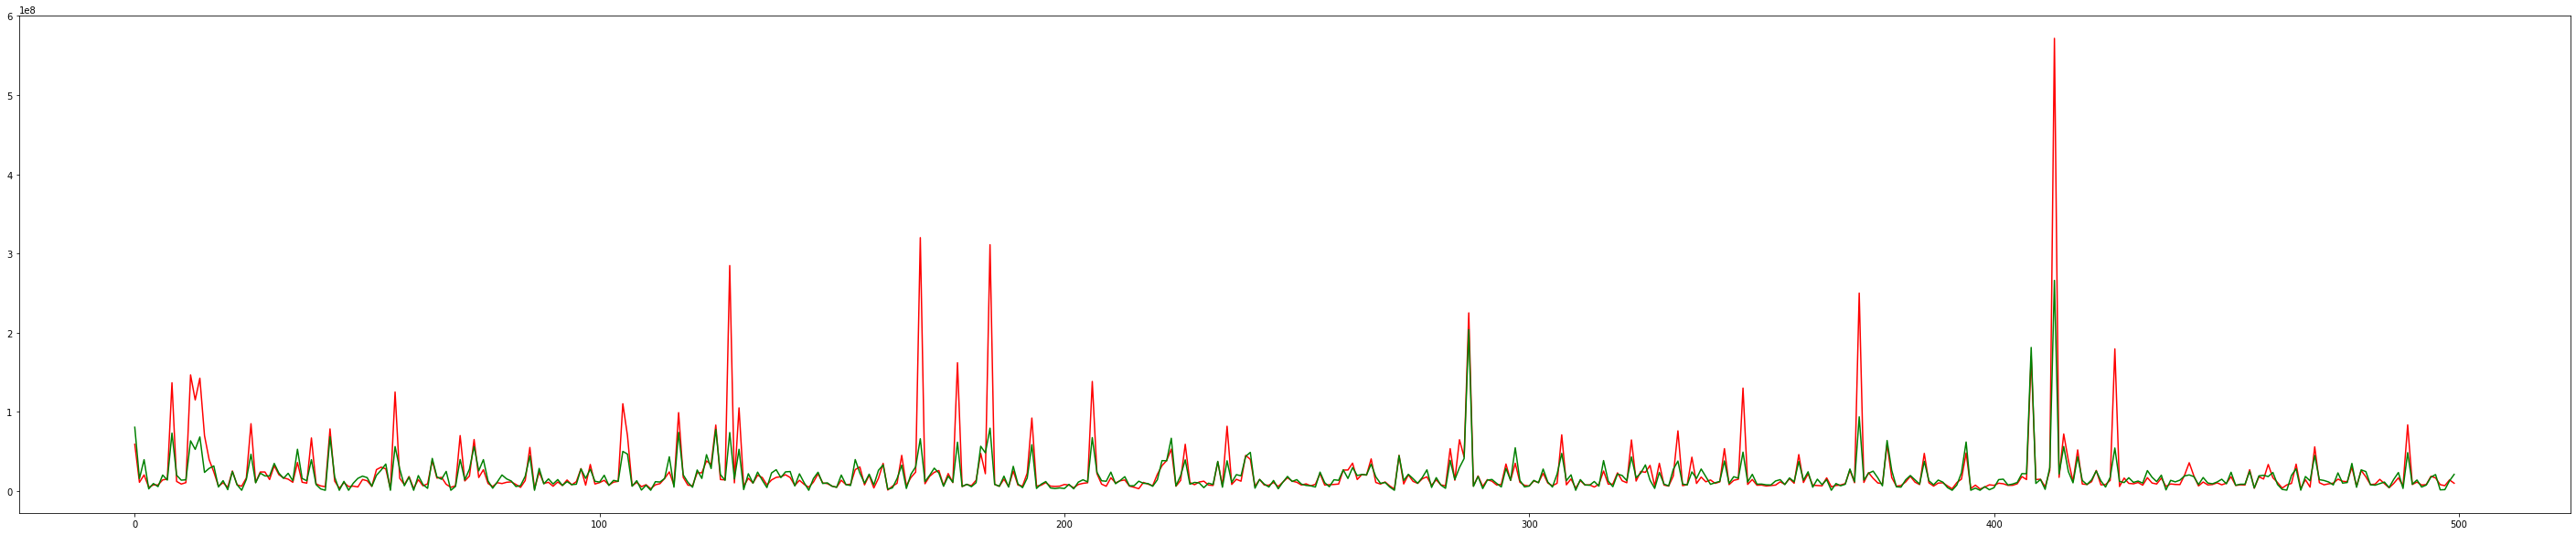

In [95]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.15)

# remove apartments with very high price from training-test data
qhigh = X_train["price"].quantile(0.95)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# fit model
reg_model_check = LinearRegression()
reg_model_check.fit(X_train, y_train)

# predict
predictions = reg_model_check.predict(X_test)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(predictions)):
    if predictions[i] < 900000:
        predictions[i] = 900000

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(predictions[:500], color = 'green')

# r2 score 
print(reg_model_check.score(X_test, y_test))
# mean squared log error
print(mean_squared_log_error(y_test, predictions))

In [96]:
train_data = dfTrain.copy()
# normalize columns training data
train_data = process_data(train_data, keep_col=['price'])

# remove apartments with very high price from training data
qhigh = train_data["price"].quantile(0.95)
train_data = train_data[(train_data["price"] < qhigh)]
y_train_data = train_data.pop("price")

# fit model
reg_model = LinearRegression()
reg_model.fit(train_data, y_train_data)

# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x'])

# separate id from test data
ids = test_data.pop("id_x")

# predict
predictions = reg_model.predict(test_data)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(predictions)):
    if predictions[i] < 900000:
        predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = predictions
submission.to_csv("predictions.csv", index=False)

# list apartments resulting in too low price
faulty_rows = []
for i in range(len(submission.values)):
    if submission.values[i][1] == 900000:
        faulty_rows.append(test_data.values[i])